# Agricultural drought Hazard Assessment 
<br>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?)

In this workflow we will assess the impact of water deficit on crop yields. 

The aim is to estimate the potential loss in yield for a given crop in the absence of an artificial irrigation system compensating for precipitation scarcity. This is particularly relevant for semi-arid regions which are increasingly prone to  prolonged drought periods making artificial irrigation unfeasible, as well as historically wet regions that have not yet implemented artificial irrigation at large-scale but might experience a significant decline in precipitation rates with future climate change. For more details, please refer to the [description](AGRICULTURE_Risk_workflow_description.md) document.

## Hazard Asssessment methodology

The starting point of the hazard assessment is the calculation of the soil standard evapotranspiration (ET0) using the Penman-Monteith equation described by FAO (Allen et al., 1998). The Penman-Monteith equation allows to calculate the reference evapotranspirative demand (i.e., how much water does a standard plant requires to live) combining thermal radiation and wind data. ET0 does not hold any plant-specific information, but represents the climate-driven evapotranspiration demand for a reference crop. 

The standard evapotranspiration is then combined with a series of crop-specific information condensed in a crop coefficient (Kc) to derive the crop standard evapotranspiration (ETc). This value represents the maximum evapotranspiration potential for a gievn crop. From ETc, it is possible to derive the actual crop evapotranspiration (ETa) using precipitation data to estimate the local water availability for the plant. Hence, ETa represents a fraction of ETc. Using the equations from the FAO I&D 33 paper (Doorenbos et al., 1979), is then possible to relate the ratio between the rainfed and the maximum evapotranspiration potential to the crop yield loss (%) in rainfed-only conditions.  

The hazard assessment can currently be performed for the 15 crops parameterised in the [crop table](crop_table.ipynb), but this can be modfied to add any crop the user might be interested in. 

### Limitations

The main limitations of this approach to calculate yield losses derive from the paramterization of the crop-specific indicators. Indeed, the thermal climate zone division is rather coarse and does not allow to accurately capture all sub-regional climate characteristics. As a consequence, the definition of the season start and end days, as well as the length of the growing period might not accurately represent the real conditions in all studied regions. However, the user can overcome these limitations by manually edit the [crop table](crop_table.ipynb) workflow and insert the parameters that best represent the local conditions they want to assess.

Another limitation derives from the use of the Doorenbos et al., (1979) equation to relate water scarcity to yield losses. On one hand, this approach has been widely used in the literature as it is extremely straight-forward but still offers a good estimate of yield reductions. On the other, more sophisticated approaches have now been developed to get more accurate quantification of aridity-related yield losses taking into account additional processes and parameters (Steduto et al., 2012). For the purpose of this workflow, the choice of the Doorenbos method seemed the most approapriate due to its long-standing solidity and computational efficiency. The user is invited to cross-check the results with those produced by more sophisticated softwares like [CropWat](https://www.fao.org/3/i2800e/i2800e.pdf) to assess the robustness of the workflow.

## Load libraries
In this notebook we will use the following Python libraries:

In [109]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
import pooch
import cdsapi
import os
import xarray as xr
import json
import urllib
import pyproj
import cartopy.crs as ccrs
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re

:::{admonition}
:class: hint dropdown 
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [pandas](https://pandas.pydata.org/docs/index.html) - To store data in the form of DataFrames.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - To extract files from zipped folders.
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) and [urllib](https://docs.python.org/3/library/urllib.html) - To download data from various repositories.
- [cdsapi](https://pypi.org/project/cdsapi/) - To download data from the Copernicus Climate Data Storage. 
- [json](https://docs.python.org/3/library/json.html) - To read GeoJson files.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format.
- [xarray](https://docs.xarray.dev/en/stable/) - To access data in netCDF4 format.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [pyproj](https://pyproj4.github.io/pyproj/stable/) - To reproject data between different coordinate systems.
- [matplotlib](https://matplotlib.org/) and [Basemap](https://matplotlib.org/basemap/stable/)  - For plotting.


## Create the directory structure
First, we need to set up the directory structure to make the workflow work.
The next cell will create the directory called 'agriculture_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [2]:
workflow_dir = 'agriculture_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area

The cells below allows to download the boundaries of any NUTS2 region in the EU as a GeoJson file given the region code (in this case ES51 for Catalunya). You can look up the NUTS2 code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [126]:
region = ['ES51'] #Replace the code in [''] with that of your region 

In [132]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326_LEVL_2.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. The coordinates are then reprojected from the source projection to the climate data projection.

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [5]:
scale=0.5

#defining region bounding box
bbox=[np.min(coords_user[:,0])-scale,np.min(coords_user[:,1])-scale,np.max(coords_user[:,0])+scale,np.max(coords_user[:,1])+scale]

#setting up the projection transformation tool
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EURO-CORDEX projection.
RLON_MIN, RLAT_MIN = transformer.transform(bbox[1], bbox[0])
RLON_MAX, RLAT_MAX = transformer.transform(bbox[3], bbox[2])

## Download the climate datasets

Climate data is sourced from the [Copenicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form). For this analysis, EURO-CORDEX climate projections for *precipitation flux, maximum temperature, minimum temperature, relative humidity, wind speed* and *solar downward radiation* at 12 km spatial resolution and *daily* temporal resolution have been employed. These projections are readily accessible to the public through the Climate Data Store (CDS) portal. The EURO-CORDEX data can be downloaded through the CDS API reported below.

For this example, we will guide you through downloading 5-year timeframes for each needed variable from the EURO-CORDEX repository. In this example the selected timeframe is 2046-2050 and the emission scenario is RCP2.6. We will also select a specific combination of General Circulation Model (GCM) and Regional Climate model (RCM). To download the data through the API below you will need to register an account on the Copernicus CDS. A complete guide on how to set up the API can be found [here](https://cds.climate.copernicus.eu/api-how-to). Once your API is set-up, replace the 'KEY' below with your own and run the cell to download the data. 

:::{warning} The download could take a few minutes (depending on your internet speed) due to the large dataset to download and the availability of the Copernicus repository. The status bar below the cell will keep you updated on the status of the download.

:::{important} Only some GCM-RCM combinations will allow you to download all the variables needed in this workflow. Extracting all the variables from the same GCM-RCM combination is important for data consistency. In this example we used **mpi_m_mpi_esm_lr** as the GCM and **knmi_racmo22e** as the RCM.

In [6]:
zip_path_cordex = os.path.join(data_dir, 'cordex_data.zip')

URL='https://cds.climate.copernicus.eu/api/v2'
KEY= None #replace with your own

c = cdsapi.Client(url=URL,key=KEY)

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'europe',
        'experiment': 'rcp_2_6',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': [
            '10m_wind_speed', '2m_relative_humidity', 'maximum_2m_temperature_in_the_last_24_hours',
            'mean_precipitation_flux', 'minimum_2m_temperature_in_the_last_24_hours', 'surface_solar_radiation_downwards'
        ],
        'gcm_model': 'mpi_m_mpi_esm_lr',
        'rcm_model': 'knmi_racmo22e',
        'ensemble_member': 'r1i1p1',
        'start_year': '2046',
        'end_year': '2050',
        'format': 'zip',
    },
    zip_path_cordex)

with zipfile.ZipFile(zip_path_cordex, 'r') as zObject:
    zObject.extractall(path=data_dir)

2024-03-28 11:45:16,596 INFO Welcome to the CDS
2024-03-28 11:45:16,612 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-03-28 11:45:16,821 INFO Request is queued
2024-03-28 11:45:17,840 INFO Request is running
2024-03-28 12:07:41,810 INFO Request is completed
2024-03-28 12:07:41,810 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data5/dataset-projections-cordex-domains-single-levels-422452ad-4115-45d2-b3b8-99461fc96211.zip to agriculture_workflow\data\cordex_data.zip (3.3G)
2024-03-28 12:15:10,506 INFO Download rate 7.6M/s                                                                      


:::{tip}
You can download data for different emission scenarios, as well as start and end years by modifying the **experiment, start_year** and **end_year** parameters in the code above. 

### Explore the data
The downloaded files from CDS have a filename structure that describes the exact dataset contained. The general structure for daily files is the following:

   {variable}-{domain}-{gcm}-{rcp}-{ensemble}-{rcm}-{version}-day-{startyear}-{endyear}

Load one of the files and explore the content and structure of the dataset. Notice the dimensions, coordinates, data variables, indexes and attributes as well as the description of the spatial reference system in rotated_pole().


In [7]:
# Open the netCDF file as a dataset using xarray
dataset_precipitation_example = xr.open_mfdataset(f'{data_dir}/pr_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_20460101-20501231.nc', 
                                                  decode_coords='all')
# Display said dataset
dataset_precipitation_example

<xarray.Dataset>
Dimensions:       (rlon: 424, rlat: 412, time: 1826, bnds: 2)
Coordinates:
    rotated_pole  |S1 ...
  * rlon          (rlon) float64 -28.38 -28.27 -28.16 ... 17.93 18.05 18.16
    lon           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat          (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    lat           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * time          (time) datetime64[ns] 2046-01-01T12:00:00 ... 2050-12-31T12...
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(1826, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr            (time, rlat, rlon) float32 dask.array<chunksize=(1826, 412, 424), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                    CF-1.4
    contact:                        Erik van Meijgaard, KNMI, Regional Climat...
    experiment:                     RCP2.6 run
    experiment_id:                  rcp26
    realization:                    1
    driving_experiment:             MPI-M-MPI-ESM-LR,rcp26,r1i1p1
    ...                             ...
    knmi_model_comment:             RACMO22E: baseline physics from ECMWF CY3...
    knmi_version_comment:           v1: reference version for Europe and othe...
    knmi_grib_path:                 mos.knmi.nl:/climreg/CXEUR12/eR2v2-v545-f...
    creation_date:                  2020-05-21T02:27:09Z
    c3s_disclaimer:                 This data has been produced in the contex...
    tracking_id:                    hdl:21.14103/393ff68d-69a9-4481-8d2f-cb63...

### Extract the climate data for the studied region

In [8]:
# Auxiliary function to slice each dataset to a particular region with rotated coordinates.
def cut_to_region(ds):
    ds = ds.sel(rlat = slice(RLAT_MIN, RLAT_MAX), rlon = slice(RLON_MIN, RLON_MAX))
    return ds

#Extraction of each variable and averaging across years

#Tmax
ds_tasmax = xr.open_mfdataset(f'{data_dir}/tasmax_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_20460101-20501231.nc', decode_coords='all',
                                     preprocess=cut_to_region)
Tmax=ds_tasmax['tasmax'][1:].to_numpy().reshape((5,365,len(ds_tasmax['rlat']),len(ds_tasmax['rlon']))).mean(axis=0)-273.15

#Tmin
ds_tasmin = xr.open_mfdataset(f'{data_dir}/tasmin_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_20460101-20501231.nc', decode_coords='all',
                                     preprocess=cut_to_region)
Tmin=ds_tasmin['tasmin'][1:].to_numpy().reshape((5,365,len(ds_tasmin['rlat']),len(ds_tasmin['rlon']))).mean(axis=0)-273.15

#Tmean
Tmean=(Tmax-Tmin)/2

#Precipitation
ds_precipitation=xr.open_mfdataset(f'{data_dir}/pr_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_20460101-20501231.nc', decode_coords='all',
                                     preprocess=cut_to_region)
precipitation=ds_precipitation['pr'][1:].to_numpy().reshape((5,365,len(ds_precipitation['rlat']),len(ds_precipitation['rlon']))).mean(axis=0)
precipitation=precipitation*86400 #conversion from kg/m2/s to mm/day

#Wind speed
ds_ws=xr.open_mfdataset(f'{data_dir}/sfcWind_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_20460101-20501231.nc', decode_coords='all',
                                     preprocess=cut_to_region)
ws=ds_ws['sfcWind'][1:].to_numpy().reshape((5,365,len(ds_ws['rlat']),len(ds_ws['rlon']))).mean(axis=0)
ws=ws*(4.87/np.log(67.8*10**-5.42)) #conversion from 10m wind speed to 2m wind speed
ws[ws<0]=0

#Relative humidity
ds_hurs = xr.open_mfdataset(f'{data_dir}/hurs_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_20460101-20501231.nc',decode_coords='all',
                      preprocess=cut_to_region)
relhum=ds_hurs['hurs'][1:].to_numpy().reshape((5,365,len(ds_hurs['rlat']),len(ds_hurs['rlon']))).mean(axis=0)

#Solar downward surface radiation
ds_rsds=xr.open_mfdataset(f'{data_dir}/rsds_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_KNMI-RACMO22E_v1_day_20460101-20501231.nc',decode_coords='all',
                      preprocess=cut_to_region)
rad=ds_rsds['rsds'][1:].to_numpy().reshape((5,365,len(ds_rsds['rlat']),len(ds_rsds['rlon']))).mean(axis=0)*0.0864 #conversion from Watts to MegaJoules


## Download the Available Water Capacity, Elevation and Thermal Climate Zones datasets

To calculate the crop evapotranspiration potential (ETc) we need information about the local Available Water Capacity, elevation and thermal climate zone. The cells below show how to download these datasets and extract information for the studied region.

### 1. Available Water Capacity

The available water capacity (AWC) represents the maximum amount of water the soil can store within a certain depth. In this workflow we are using data for soil depths of 0-200 cm. The data are sourced from Hengl and Gupta (2019). The cell below downloads the data as a .tif file from the zenodo repository and saves it in the data directory.

In [9]:
url = 'doi:10.5281/zenodo.2629149/sol_available.water.capacity_usda.mm_m_250m_0..200cm_1950..2017_v0.1.tif'
filename = 'sol_available.water.capacity_usda.mm_m_250m_0..200cm_1950..2017_v0.1.tif'
from pooch import DOIDownloader
pooch.retrieve(
    url=url,known_hash='md5:07129d7ed5e7d1457677bdedee926b27',fname=filename,
    path=data_dir,downloader=DOIDownloader())

'C:\\Users\\rivoc\\cmcc_results\\climaax\\agriculture_workflow\\data\\sol_available.water.capacity_usda.mm_m_250m_0..200cm_1950..2017_v0.1.tif'

### 2. Elevation

Elevation data are sourced from the USGS GDTEM 2010 digital elevation model (Danielson & Gesch, 2011). This dataset has relatively coarse resolution compared to more recent DEM, but it is adequate for the resolution of this assessment. The cell below downloads the DEM at 30 arc-second resolution as a .zip folder, then extracts it in the data directory. 

In [10]:
url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/topo/downloads/GMTED/Grid_ZipFiles/mn30_grd.zip'
filename = 'mn30_grd.zip'
pooch.retrieve(
    url=url,fname=filename,
    known_hash=None,
    path=data_dir)
with zipfile.ZipFile(f'{data_dir}/mn30_grd.zip', 'r') as zObject:
    zObject.extractall(path=data_dir)

### 3. Thermal Climate Zones

The thermal climate zones represent a classification of global climates in 8 categories characterised by different annual temperature ranges and rain seasons (Van Velthuizen, 2007). This classification is helpful for agricultural modelling as crops have different growing calendars and evapotranspirative responses depending on the temperature/precipitation regime. 
The cell below downloads the thermal climate zones raster from the FAO repository as a .zip folder and extracts it in the data directory. 

In [11]:
url = 'https://storage.googleapis.com/fao-maps-catalog-data/uuid/68790fd0-690c-11db-a5a5-000d939bc5d8/resources/Map4_1.zip'
filename = 'Map4_1.zip'
pooch.retrieve(
    url=url,fname=filename,
    known_hash=None,
    path=data_dir)

with zipfile.ZipFile(f'{data_dir}/Map4_1.zip', 'r') as zObject:
    zObject.extractall(path=data_dir)

### Extract the AWC, elevation and thermal climate zones data for the studied region

In [12]:
#Select the lon and lat coordinates from one of the climate datasets extracted before and create an array of points
lons=ds_tasmax['lon']
lats=ds_tasmax['lat']
lons=lons.to_numpy().reshape((-1,1))
lats=lats.to_numpy().reshape((-1,1))
coords_11=np.hstack((lons,lats))

#Sample each raster file at the coordinates found above and save the data
raster_path = f'{data_dir}/sol_available.water.capacity_usda.mm_m_250m_0..200cm_1950..2017_v0.1.tif'
dff=pd.DataFrame()
with rasterio.open(raster_path) as src:
    nodata_value = src.nodata
    input_crs = src.crs
    dff['AWC'] = [x[0] for x in src.sample(coords_11)]  
AWC=dff['AWC'].to_numpy(dtype='float64')
AWC[AWC<0]=0
AWC=AWC.reshape(len(Tmax[0,:,0]),len(Tmax[0,0,:]))

raster_path=f'{data_dir}/mn30_grd/w001001.adf'
dfa=pd.DataFrame()
with rasterio.open(raster_path) as src:
    nodata_value = src.nodata
    input_crs = src.crs
    dfa['elev'] = [x[0] for x in src.sample(coords_11)]    
elev=dfa['elev'].to_numpy(dtype='float64')
elev=elev.reshape(len(Tmax[0,:,0]),len(Tmax[0,0,:]))

raster_path = f'{data_dir}/therm_clim/w001001.adf'
dfx=pd.DataFrame()
with rasterio.open(raster_path) as src:
    nodata_value = src.nodata
    input_crs = src.crs
    dfx['clim'] = [x[0] for x in src.sample(coords_11)] 
climate_zone=dfx['clim'].to_numpy(dtype='float64')  
climate_zone[climate_zone<0]=dfx['clim'].mode()
climate_zone=climate_zone.reshape(len(Tmax[0,:,0]),len(Tmax[0,0,:]))


### Explore the data
Now that we have extracted the data, you can simply call the AWC, elev and climate_zone variables to visualise them. All variables are stored as a [numpy array](https://numpy.org/doc/stable/user/absolute_beginners.html) and have the same shape (i.e., lon x lat dimension) of the climate datasets.
<br>
To see the shape of the extracted files:

In [13]:
elev.shape 

(24, 34)

This tells us that in this case, the extracted area is formed by a lon-lat grid of 19x19 12.5 km pixels.

## Import crop-specific information

Crop specific paramters needed for the hazard assessment are imported from the [crop table]() workflow. The cell below reads the output file of the crop table workflow and prints it.

In [14]:
%run crop_table.ipynb
crop_table=pd.read_csv(f'{data_dir}/crop_table.csv')
crop_table

,FAO_Code,Crop,Clim,Kc_in,Kc_mid,Kc_end,lgp_f1,lgp_f2,lgp_f3,lgp_f4,Season start,Season End,RD1,RD2,DF,Type,Ky
0,1111,wheat,2,0.70,1.15,0.30,0.125000,0.208333,0.416667,0.250000,135.0,255.0,0.2,1.25,0.55,1,1.0
1,1111,wheat,3,0.70,1.15,0.30,0.111111,0.333333,0.388889,0.166667,319.0,134.0,0.2,1.25,0.55,1,1.0
2,1111,wheat,4,0.70,1.15,0.30,0.477612,0.223881,0.223881,0.074627,289.0,259.0,0.2,1.25,0.55,1,1.0
3,1111,wheat,5,0.70,1.15,0.30,0.111111,0.333333,0.388889,0.166667,336.0,151.0,0.2,1.25,0.55,1,1.0
4,1111,wheat,7,0.40,1.15,0.30,0.477612,0.223881,0.223881,0.074627,320.0,290.0,0.2,1.25,0.55,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,270,rapeseed,3,0.35,1.15,0.35,0.200000,0.400000,0.200000,0.200000,153.0,303.0,0.2,1.00,0.60,1,1.0
86,270,rapeseed,4,0.35,1.15,0.35,0.200000,0.400000,0.200000,0.200000,122.0,302.0,0.2,1.00,0.60,1,1.0
87,270,rapeseed,5,0.35,1.15,0.35,0.200000,0.400000,0.200000,0.200000,259.0,74.0,0.2,1.00,0.60,1,1.0
88,270,rapeseed,7,0.35,1.15,0.35,0.200000,0.400000,0.200000,0.200000,136.0,316.0,0.2,1.00,0.60,1,1.0


The resulting table is a [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) that you can explore using the column keys. For instance, to check information for all available crops in the temperate oceanic climate zone you can use: 

:::{tip} A complete description of the crop table is available in the [crop table](crop_table.ipynb) workflow.

In [15]:
crop_table[(crop_table["Clim"] == 4)]

,FAO_Code,Crop,Clim,Kc_in,Kc_mid,Kc_end,lgp_f1,lgp_f2,lgp_f3,lgp_f4,Season start,Season End,RD1,RD2,DF,Type,Ky
2,1111,wheat,4,0.70,1.15,0.30,0.477612,0.223881,0.223881,0.074627,289.0,259.0,0.2,1.25,0.55,1,1.00
8,113,maize,4,0.30,1.20,0.50,0.200000,0.200000,0.266667,0.333333,106.0,256.0,0.2,1.00,0.55,1,1.50
14,112,rice,4,1.05,1.20,0.90,0.200000,0.200000,0.400000,0.200000,122.0,302.0,0.2,0.50,0.20,1,1.35
20,114,barley,4,0.30,1.15,0.25,0.477612,0.223881,0.223881,0.074627,289.0,259.0,0.2,1.00,0.55,1,1.00
26,1152,sorghum,4,0.30,1.00,0.55,0.160000,0.280000,0.320000,0.240000,92.0,217.0,0.2,1.00,0.55,1,0.90
32,14202,soybean,4,0.40,1.15,0.50,0.133333,0.166667,0.500000,0.200000,122.0,272.0,0.2,0.60,0.50,1,0.85
38,14204,sunflower,4,0.35,1.15,0.35,0.192308,0.269231,0.346154,0.192308,122.0,252.0,0.2,0.80,0.45,1,0.95
44,121,potato,4,0.50,1.15,0.75,0.206897,0.241379,0.344828,0.206897,92.0,237.0,0.2,0.40,0.35,1,1.10
50,2113,citrus,4,0.70,0.65,0.70,0.164384,0.246575,0.328767,0.260274,15.0,15.0,1.1,1.10,0.50,2,0.95
56,21605,date_palm,4,0.90,0.95,0.95,0.328767,0.164384,0.493151,0.013699,15.0,15.0,1.5,1.50,0.50,2,0.80


## Hazard calculation

First, you will have to select the crops you want to assess. In this example we are using wheat and maize.

:::{warning}
Write the crop names inside the crop_list exactly how they are written in the crop table.

:::{important} You can select as many crops as you want, but the **more** the **longer** the workflow will take to complete.

In [16]:
#Select crops to study
crop_list = ["maize", "wheat"]

The cell below creates empty arrays to be filled with the outputs of the calculations. Some of them are only required for debugging and validation purposes, but advanced users might want to explore them. 

In [17]:
# Create empty arrays for different parameters

#Fundamental
Irr_req = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ETa_rf = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ETa_irr= np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
yield_loss_perc = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list)])

#Validation
kc_daily = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ks_daily = np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
deficit_meteo_daily=np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
daily_rooting_depth_all= np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
prec_eff_daily= np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])
ET0_daily=np.zeros([len(Tmax[0,:,0]),len(Tmax[0,0,:]),len(crop_list),365])

### Reference soil evapotranspiration potential (ET0)
The cell below defines an auxiliary function to compute the daily reference evaportanspiration potential (ET0) in every cell of the selected region following the FAO56 methodology (Allen et al., 1998). The user is referred to Zotarelli et al., (2009) for a synthetic, step-by-step guide on how the calculation is performed.

In [18]:
def FAO_56_ET0(Tmax,Tmin,Tmean,relhum,ws,lat_radians,elev,rad,albedo_crop):
                es_Tx = 0.6108 * np.exp((17.27 * Tmax[day,lat,lon]) / (Tmax[day,lat,lon] + 237.3))  # Mean Saturation vapor Pressure [KPa]
                es_Tn = 0.6108 * np.exp((17.27 * Tmin[day,lat,lon]) / (Tmin[day,lat,lon] + 237.3))
                es = ((es_Tx + es_Tn) / 2) #mean sat vapour pressure
                ea = relhum[day,lat,lon]/100 * es  # rel_hum as fraction
                P_barometrica = 101.3 * ((293 - 0.0065 * elev[lat,lon]) / 293)**5.26# Psychrometric constant, [kPa C-1]
                gamma = (P_barometrica * 0.001013) / (0.622 * 2.45)
                Delta = 4098 * (0.6108 * np.exp((17.27 * Tmean[day,lat,lon]) / (Tmean[day,lat,lon] + 237.3))) / ((Tmean[day,lat,lon] + 237.3)**2) # Slope of Saturation Vapor Pressure [kPa C-1]
                DT=Delta/(Delta+gamma*(1+0.34*ws[day,lat,lon]))
                PT=gamma/(Delta+gamma*(1+0.34*ws[day,lat,lon]))
                TT=(900/(Tmean[day,lat,lon]+273.15))*ws[day,lat,lon]
                #rad component
                dist_sun=1+0.0033*np.cos(2*np.pi/365*day)
                sol_decl=0.409*np.sin(0.0172*day-1.39)
                suns_angle=np.arccos(-np.tan(lat_radians[lat,lon])*np.tan(sol_decl))
                Ra=37.6*dist_sun*(suns_angle*np.sin(lat_radians[lat,lon])*np.sin(sol_decl)+np.cos(lat_radians[lat,lon])*np.cos(sol_decl)*np.sin(suns_angle))
                Rs0=(0.75+2*10**-5*elev[lat,lon])*Ra
                Rnet=(rad[day,lat,lon]*(1-albedo_crop))-(4.903*(10**-9)*((Tmax[day,lat,lon]+273.15)**4+(Tmin[day,lat,lon]+273.15)**4)/2)*(0.34-0.14*np.sqrt(ea))*(1.35*np.where(rad[day,lat,lon]/Rs0<=1,rad[day,lat,lon]/Rs0,1)-0.35)
                #ET0 = ((0.408 * 0.0864 * (Rnet - G) * Delta) + (gamma * 900 * ws[day,lat,lon] * VPD / (Tmean[day,lat,lon] + 273.15))) / (Delta + (gamma * (1 + (rs / ra)))) # Potential EvapoTranspiration [mm day-1]
                ET0 = 0.408*Rnet+DT + PT*TT*(es-ea) #ET0=Rng+DT+PT*TT*(es-ea)
                #ET0_daily[lat,lon,i,day]=ET0
                return ET0

### Yield percentage reduction
The cell below combines the ET0 calculation results with the precipitation data and the crop specific parameters to compute the percentage yield loss from irrigation deficit. The main calculation steps are described within the cell.

:::{warning} The calculation might take a few minutes, especially if a large region is selected.

In [19]:
#create dataframe where results will be stored
columns=['rcp','start_year','end_year','lat','lon']
columns.extend(crop_list)
yield_file=pd.DataFrame(columns=columns)
yield_file['lon']=coords_11[:,0]
yield_file['lat']=coords_11[:,1]

yield_file['rcp']=ds_tasmax.attrs['experiment_id']
yield_file['start_year']=ds_tasmax['time.year'][0].to_numpy()
yield_file['end_year']=ds_tasmax['time.year'][-1].to_numpy()

In [20]:
initial_SM = 0  # Initial Soil Moisture,user-defined value [m^3/m^3]
sowing_SM = 0  # Sowing Soil Moisture,user-defined value [m^3/m^3]

#CONSTANTS NEEDED FOR ET0 CALCULATION
zm = 10  # height of wind measurements [m]
zh = 2  # height of humidity measurements [m]
h = 0.12  # crop height [m]
albedo_crop = 0.23  #constant
G=0 #for daily time-steps in Et0 calculation
lat_radians=np.deg2rad(coords_11[:,1]).reshape((len(Tmax[0,:,0]),len(Tmax[0,0,:])))

deficit_start=0 #water deficit of first day

for crop in crop_list:
    for lat in np.arange(len(Tmax[0,:,0])):
        for lon in np.arange(len(Tmin[0,0,:])):
            for day in range(1, 365):
                i = crop_list.index(crop)
                row = crop_table[(crop_table["Crop"] == crop) & (crop_table["Clim"] == climate_zone[lat,lon])]

                # Length of Growing Periods, kc values, and rooting depth
                season_start = row.iloc[0, 10]
                season_end = row.iloc[0, 11]

                if season_start < season_end:
                    LGP = season_end - season_start + 1
                else:
                    LGP = season_end - season_start + 366

                # Definition of kc
                kc_in = row.iloc[0, 2]
                kc_mid = row.iloc[0, 3]
                kc_end = row.iloc[0, 4]

                # Definition of period
                L1 = round(LGP * row.iloc[0, 5])
                L2 = round(LGP * row.iloc[0, 6])
                L3 = round(LGP * row.iloc[0, 7])
                L4 = LGP - (L1 + L2 + L3)

                L12 = L1 + L2
                L123 = L1 + L2 + L3
                L2_den = L2
                L4_den = L4
                L12_den = L12

                s = season_start
                h = season_end

                # Definition of rooting depth
                RD = row.iloc[0, [12, 13]]
                
                #calculation of ET0
                ET0=FAO_56_ET0(Tmax,Tmin,Tmean,relhum,ws,lat_radians,elev,rad,albedo_crop)
                ET0_daily[lat,lon,i,day]=ET0
            
            # Determination of effective rainfall prec_eff (Mancosu et al., 2015)
                if (h >= s) & (day >= s):
                    prec_eff=np.where(precipitation[day,lat,lon]  < (ETa_irr[lat,lon,i,day-1]+deficit_final),
                                      precipitation[day,lat,lon],ETa_irr[lat,lon,i,day-1]+deficit_final)
                elif (h >= s) & (day < s):
                    ETa_irr[lat,lon,i,day] = 0 # if day=1 there is no ETa  
                    deficit_final=deficit_start
                    prec_eff=0
                elif (h<s) & (day<s) & (day>h):
                    ETa_irr[lat,lon,i,day] = 0 # if day=1 there is no ETa  
                    deficit_final=deficit_start
                    prec_eff=0
                else:
                    prec_eff=np.where(precipitation[day,lat,lon]  < (ETa_irr[lat,lon,i,day-1]+deficit_final),
                                      precipitation[day,lat,lon],ETa_irr[lat,lon,i,day-1]+deficit_final)
                
                prec_eff_daily[lat,lon,i,day]=prec_eff

                #1st step: calculation of crop coefficient Kc   
                kc = np.where((h > s) & (day >= s) & (day < (s + L1 - 1)), kc_in, 0) + np.where(
                    (h > s) & (day >= (s + L1 - 1)) & (day < (s + L12 - 1)), kc_in + ((day - (s + L1) + 1) / L2_den) * (kc_mid - kc_in), 0) + np.where(
                    (h > s) & (day >= (s + L12 - 1)) & (day < (s + L123 - 1)), kc_mid, 0) + np.where(
                    (h > s) & (day >= (s + L123 - 1)) & (day <= h),kc_mid + ((day - (s + L123) + 1) / L4_den) * (kc_end - kc_mid), 0) + np.where(
                    (h < s) & (day >= s) & (day < (s + L1 - 1)), kc_in, 0) + np.where(
                    (h < s) & (day < (h - (LGP - L1))), kc_in, 0) + np.where(
                    (h < s) & (day >= (s + L1 - 1)) & (day < (s + L12 - 1)),kc_in + ((day - (s + L1) + 1) / L2_den) * (kc_mid - kc_in), 0)+ np.where(
                    (h < s) & (day >= (h - (LGP - L1))) & (day < (h - (LGP - L12))), kc_in + ((366 - s - L1 + day) / L2_den) * (kc_mid - kc_in), 0) + np.where(
                    (h < s) & (day >= (s + L12 - 1)) & (day < (s + L123 - 1)), kc_mid, 0) + np.where(
                    (h < s) & (day >= (h - (LGP - L12))) & (day < (h - (LGP - L123))), kc_mid, 0) + np.where(
                    (h < s) & (day >= (s + L123 - 1)) & (day <= (s + LGP - 1)),kc_mid + ((day - (s + L123) + 1) / L4_den) * (kc_end - kc_mid), 0) +np.where(
                    (h < s) & (day >= (h - (LGP - L123))) & (day <= h),kc_mid + ((366 - s - L123 + day) / L4_den) * (kc_end - kc_mid), 0)

                kc_daily[lat,lon,i,day]=kc

                # 2nd step: increment of Soil Moisture due to Precipitation input

                if row.iloc[0, 15] ==1: # annual crops
            # Annual crops
                    daily_rooting_depth = (np.where((s < h) & (s <= day) & (s + L12 - 1 > day),(RD[1] - RD[0]) / L12_den * (day - s + 1) + RD[0],0)+
                                           np.where((s < h) and (s + L12 - 1 <= day) and (day <= h),RD[1],0)+
                                           np.where((s > h) and (s <= day) and (s + L12 - 1 > day),((RD[1] - RD[0]) / L12_den) * (day - s + 1) + RD[0],0)+
                                           np.where((s > h) and (h - LGP - L12>day),((RD[1] - RD[0]) / L12_den) * (day - s + 1) + RD[0],0)+
                                           np.where((s > h) and (s + L12 - 1<= day),RD[1],0)+
                                           np.where((s > h) and (h >= day) and (h - LGP - L12 <= day), RD[1],0))
                    deficit_meteo = np.where(day == s, (AWC[lat,lon] - sowing_SM) * 1000 * daily_rooting_depth + 
                                             (AWC[lat,lon] - initial_SM) * 1000 * daily_rooting_depth,(AWC[lat,lon] - initial_SM) * 1000 * daily_rooting_depth - prec_eff)
                else: # Perennial crops
                    daily_rooting_depth = RD[1]
                    deficit_meteo = (AWC[lat,lon] - initial_SM) * 1000 * daily_rooting_depth - prec_eff 
                deficit_meteo_daily[lat,lon,i,day]=deficit_meteo
                daily_rooting_depth_all[lat,lon,i,day]=daily_rooting_depth


            # 3rd step: calculation of daily maximum water capacity in the rooting zone (TAW) and amount of water available until water stress occurs (RAW)
                TAW = AWC[lat,lon] * daily_rooting_depth #no need for *1000 as AWC units already converted
                RAW = AWC[lat,lon] * daily_rooting_depth * row.iloc[0, 14] #no need for *1000 as AWC units already converted

            # 4th step: water-stress coefficient
                ks = np.where((TAW>0) & (TAW - deficit_meteo > 0), (TAW - deficit_meteo) / (TAW - RAW), 0)
                ks[ks > 1] = 1
                ks_daily[lat,lon,i,day]=ks


            # 5th step: calculation of Actual Evapotranspiration
                ETc = ET0*kc
                ETa = ET0* kc * ks
                ETa_rf[lat,lon,i,day] = ETa
                ETa_irr[lat,lon,i,day]= ETc #ETa in condizioni di field capacity (ks=1)

            # 6th step: reduction of Soil Moisture due to Actual Evapotranspiration
                deficit_final = np.where((deficit_meteo >= 0) & (deficit_meteo <= TAW),deficit_meteo + ETa,
                                TAW)

                deficit_final_limit = TAW - ks * (TAW - RAW)  # Deficit_max = RAW

            # 7th step: irrigation requirement, expressed as difference in maximum vs actual evapotranspiration
                irrigation = np.where(ETa_rf[lat,lon,i,day] <= ETa_irr[lat,lon,i,day],
                                  ETa_irr[lat,lon,i,day] - ETa_rf[lat,lon,i,day], 0)

            # wat_soil: additional water required to bring soil moisture at required amount
                wat_soil = np.where(((deficit_final - deficit_final_limit) >= 0)
                                & ((deficit_final - deficit_final_limit) >= ETa_irr[lat,lon,i,day]),
                                deficit_final - deficit_final_limit - irrigation, 0)

            # 8° step: total irrigation requirement
                Irr_req[lat,lon,i,day] = irrigation + wat_soil

            # 9° step: calculation of final soil moisture at the end of the day
                final_SM = AWC[lat,lon] - ((deficit_final - Irr_req[lat,lon,i,day]) / (1000 * daily_rooting_depth))
                initial_SM = final_SM

    # Yield water response calculation based on FAO I&D n.33 procedure (Doorenbos et al., 1979). 
            ky = row.iloc[0, 16]
            ETa_rf[ETa_rf==0]=np.nan
            ETa_irr[ETa_irr==0]=np.nan
            annual_ETa_rf=np.nanmean(ETa_rf,axis=3)
            annual_ETa_irr=np.nanmean(ETa_irr,axis=3)
            yield_loss_perc= (ky * (1 - annual_ETa_rf / annual_ETa_irr))*100 #yield loss expressed as percentage loss from maximum yield 
            yield_file[crop]=yield_loss_perc[:,:,i].reshape(len(Tmax[0,:,0])*len(Tmax[0,0,:]))


#save the output as a spreadsheet for visualization and a numpy file to be used in the risk assessment
yield_file.to_csv(f'{results_dir}/'+str(nuts.iloc[0,4])+'_yield_loss_SPREADSHEET.csv',index=False)
np.save(f'{results_dir}/'+str(nuts.iloc[0,4])+'_yield_loss_NUMPY',yield_loss_perc)

C:\Users\rivoc\AppData\Local\Temp\ipykernel_18768\229855694.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_rooting_depth = (np.where((s < h) & (s <= day) & (s + L12 - 1 > day),(RD[1] - RD[0]) / L12_den * (day - s + 1) + RD[0],0)+
C:\Users\rivoc\AppData\Local\Temp\ipykernel_18768\229855694.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.where((s < h) and (s + L12 - 1 <= day) and (day <= h),RD[1],0)+
C:\Users\rivoc\AppData\Local\Temp\ipykernel_18768\229855694.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

## Plotting the results

The cell below allows to plot the percentage yield loss results for the studied region. The resulting plot states the crop, RCP scenario and reference period used in the assessment. The plotting procedure steps are described within the cell.

:::{tip} Use the 'zoom' paramerter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out,1=100 km). Here a zoom of 0.5 degrees (50 km) is used.

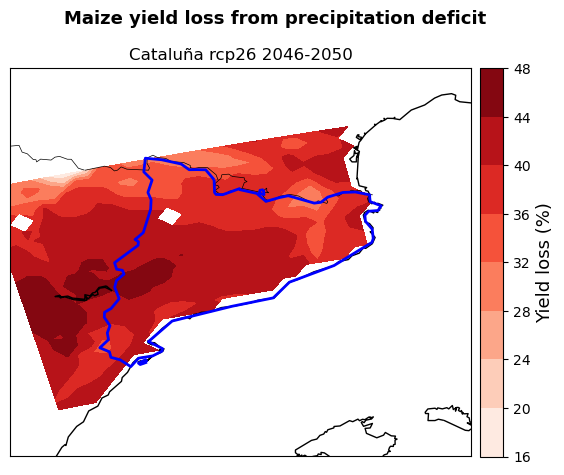

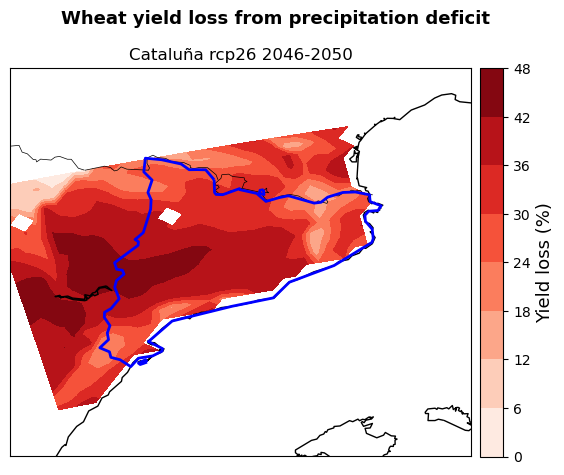

In [133]:
rcp=ds_tasmax.attrs['experiment_id'] #identify the climate projection
ystart=ds_tasmax['time.year'][0].to_numpy() #identify the projection start year
yend=ds_tasmax['time.year'][-1].to_numpy() #identify the projection end year
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=ds_tasmax['lon'].to_numpy()
lat_plot=ds_tasmax['lat'][:].to_numpy()

for a in np.arange(len(crop_list)):
    #create the basemap around the region boundaries
    map_yield =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

    map_yield.drawcoastlines()
    map_yield.drawcountries()
    #plot the yield loss
    map_yield.contourf(lon_plot,lat_plot,yield_loss_perc[:,:,a],cmap='Reds',zorder=1) 
    map_yield.colorbar().set_label('Yield loss (%)',fontsize=13)
    map_yield.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.suptitle(crop_list[a].title()+' yield loss from precipitation deficit',fontsize=13,fontweight='bold') #title
    plt.title(str(nuts.iloc[0,4])+' '+rcp+' '+str(ystart)+'-'+str(yend)) #subtitle
    plt.tight_layout()
    plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_'+str(crop_list[a])+'_yield_loss.png') #save plots in results directory
    plt.show()

## Contributors

Euro-Mediterranean Center on Climate Change (CMCC), Italy.

Author of the workflow: Andrea Rivosecchi

### References

- Allen, R.G., Pereira, L.S., Raes, D. & Smith, M. (1998) Crop evapotranspiration-Guidelines for computing crop water requirements-FAO Irrigation and drainage paper 56. Fao, Rome. 300 (9), D05109.
- Doorenbos, J. & Kassam, A.H. (1979) Yield response to water. Irrigation and drainage paper. 33, 257.
- Mancosu, N., Spano, D., Orang, M., Sarreshteh, S. & Snyder, R.L. (2016) SIMETAW# - a Model for Agricultural Water Demand Planning. Water Resources Management. 30 (2), 541–557. doi:10.1007/s11269-015-1176-7.
- Steduto, P., Hsiao, T.C., Fereres, E. & Raes, D. (2012) Crop yield response to water. FAO Rome.
